In [1]:
#import all the necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

In [2]:
#Let's read the dataset first
df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### EDA Analysis

In [3]:
df.shape

(167, 10)

In [4]:
df['ID'] = df.index+100

In [5]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,100
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,101
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,102
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,103
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,104


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
ID            167 non-null int64
dtypes: float64(7), int64(3), object(1)
memory usage: 14.5+ KB


In [8]:
#Converting % values into actual numbers
df[["exports","health","imports"]]=df[["exports","health","imports"]].apply(lambda x: x*df.gdpp/100)
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,100
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,101
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,102
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,103
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,104


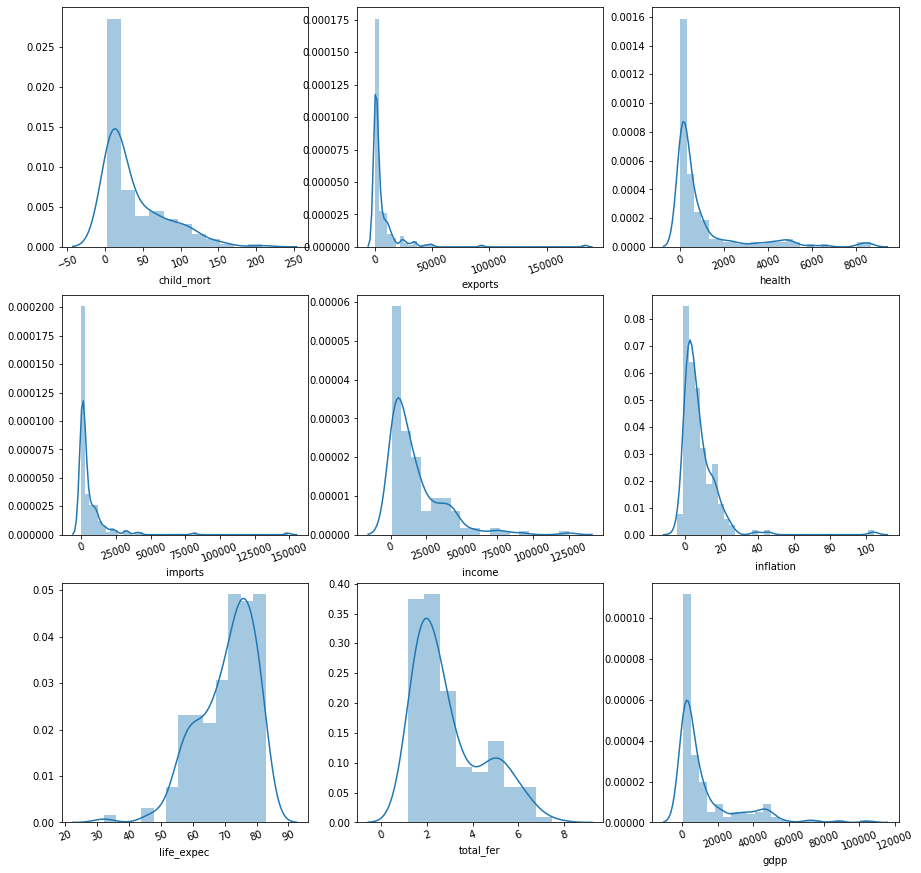

In [10]:
plt.figure(figsize=(15,15))
features = ['child_mort', 'exports', 'health', 'imports','income','inflation','life_expec','total_fer','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(df[i[1]])
    plt.xticks(rotation = 20)

In [11]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
ID            0
dtype: int64

### Outlier Treatment

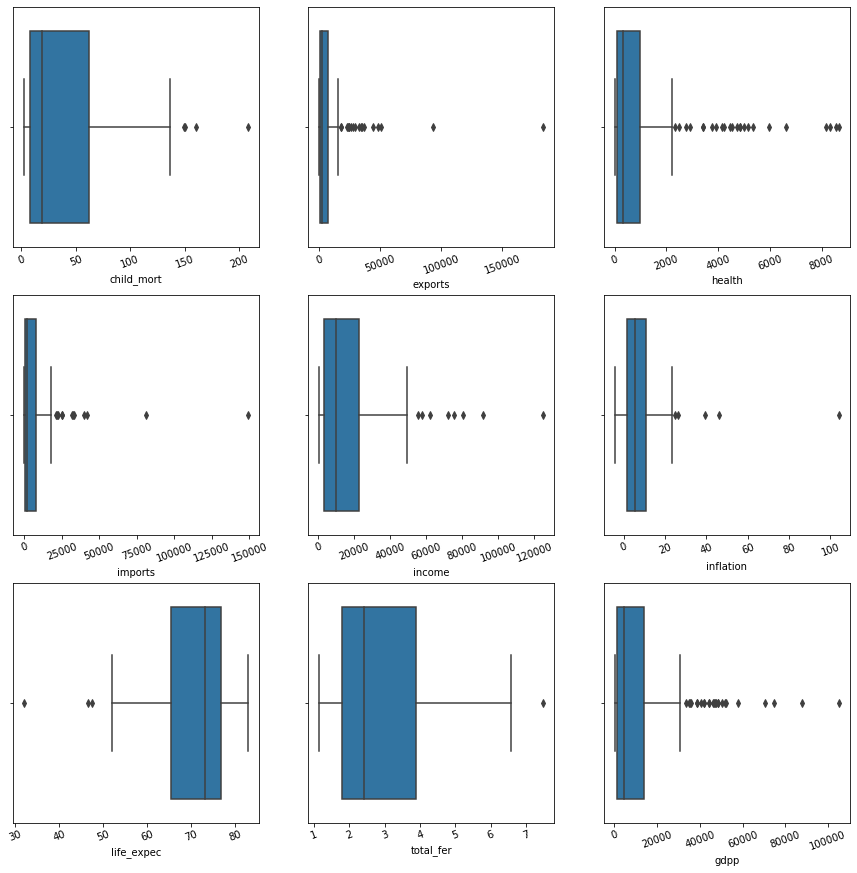

In [12]:
plt.figure(figsize=(15,15))
features = ['child_mort', 'exports', 'health', 'imports','income','inflation','life_expec','total_fer','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(3, 3, i[0]+1)
    sns.boxplot(x=i[1], data=df)
    plt.xticks(rotation = 20)

In [86]:
#Used capping technique for outlier treatment
features = ['child_mort', 'exports', 'imports','income','inflation','life_expec','gdpp']
for i in features: 
    Q1 = df[i].quantile(0.01)
    Q4 = df[i].quantile(0.99)
    df[i][df[i] <= Q1]=Q1
    df[i][df[i] >= Q4]=Q4
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null float64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null float64
ID            167 non-null int64
dtypes: float64(9), int64(1), object(1)
memory usage: 14.5+ KB


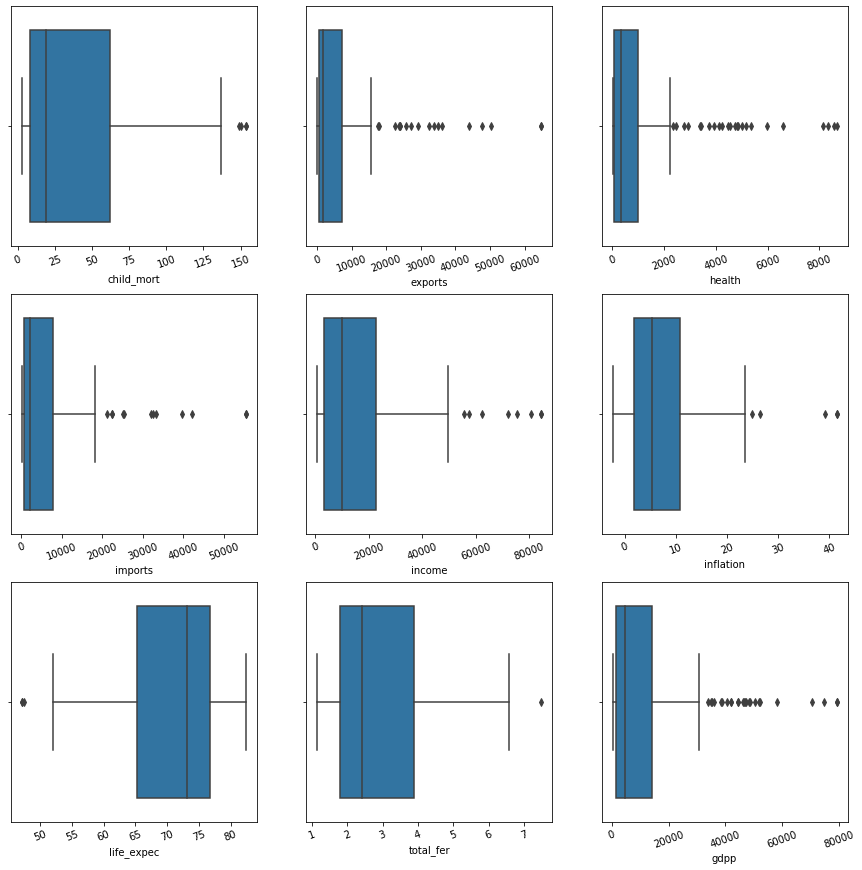

In [15]:
plt.figure(figsize=(15,15))
features = ['child_mort', 'exports', 'health', 'imports','income','inflation','life_expec','total_fer','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(3, 3, i[0]+1)
    sns.boxplot(x=i[1], data=df)
    plt.xticks(rotation = 20)

### Hopkins Statistics

In [16]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [18]:
hopkins(df.drop(['ID','country'], axis = 1))

0.9639425593061799

In [24]:
df1 = df.drop('ID', axis = 1)

In [25]:
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


### Scaling the data

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df2 = scaler.fit_transform(df1.drop('country',axis=1))

In [33]:
df2 = pd.DataFrame(df2)
df2.columns = ['child_mort', 'exports', 'health', 'imports','income','inflation','life_expec','total_fer','gdpp']


In [34]:
df2.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344012,-0.569638,-0.565040,-0.598844,-0.851772,0.263649,-1.693799,1.902882,-0.702314
1,-0.547543,-0.473873,-0.439218,-0.413679,-0.387025,-0.375251,0.663053,-0.859973,-0.498775
2,-0.272548,-0.424015,-0.484826,-0.476198,-0.221124,1.123260,0.686504,-0.038404,-0.477483
3,2.084186,-0.381264,-0.532363,-0.464070,-0.612136,1.936405,-1.236499,2.128151,-0.531000
4,-0.709457,-0.086754,-0.178771,0.139659,0.125202,-0.768917,0.721681,-0.541946,-0.032079


### K- means Clustering

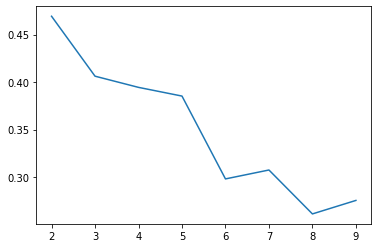

In [37]:
#First we'll do the silhouette score analysis
from sklearn.metrics import silhouette_score
ss = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k).fit(df2)
    ss.append([k, silhouette_score(df2, kmeans.labels_)])
    
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1]);

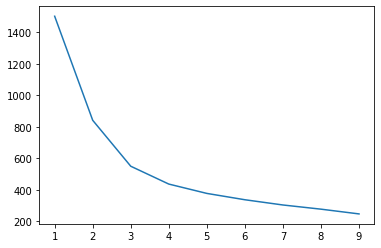

In [38]:
#Now let's proceed to the elbow curve method
ssd = []
for k in list(range(1,10)):
    model = KMeans(n_clusters = k, max_iter = 50).fit(df2)
    ssd.append([k, model.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1]);

In [39]:
#Let's perform K means using K=3
kmean = KMeans(n_clusters = 3, max_iter = 50, random_state = 50)
kmean.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [40]:
## Let's make a copy of our original data before using it for analysis
df_org = df.copy()

In [41]:
col = df.columns
col

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'ID'],
      dtype='object')

In [42]:
# Let's add the cluster Ids to the original data 
df_km = pd.concat([df.reset_index().drop('index', axis = 1), pd.Series(kmean.labels_)], axis = 1)
df_km.columns = ['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'ID', 'cluster_id']
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,100,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,101,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,102,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,103,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,104,2


In [43]:
# Cross-check
df_km.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
ID            0
cluster_id    0
dtype: int64

In [44]:
# Check the count of observation per cluster
df_km['cluster_id'].value_counts()

2    90
1    48
0    29
Name: cluster_id, dtype: int64

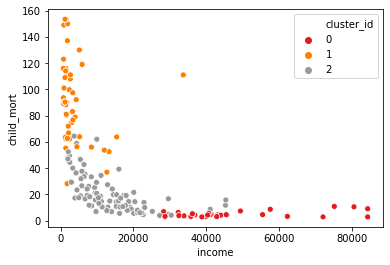

In [45]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'income', y = 'child_mort', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

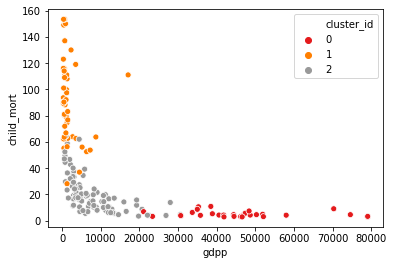

In [46]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

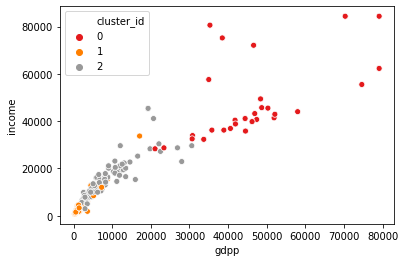

In [47]:
sns.scatterplot(x = 'gdpp', y = 'income', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

### Cluster Profiling

In [48]:
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,100,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,101,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,102,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,103,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,104,2


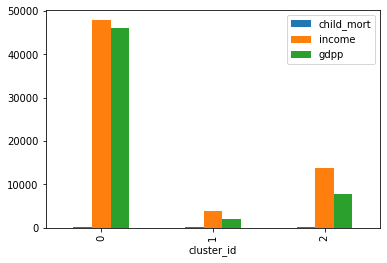

In [51]:
df_km.drop('ID', axis = 1).groupby('cluster_id')['child_mort','income','gdpp'].mean().plot(kind = 'bar')

In [58]:
df_km.drop('ID', axis = 1).groupby('cluster_id')['child_mort','income','gdpp'].mean()

,child_mort,income,gdpp
cluster_id,,,
0,4.989655,47784.413793,46068.137931
1,90.335417,3901.010000,1911.400833
2,20.547778,13804.333333,7808.577778


,cluster_id,child_mort,income,gdpp
0,0,4.989655,47784.413793,46068.137931
1,1,90.335417,3901.010000,1911.400833
2,2,20.547778,13804.333333,7808.577778


In [57]:
#Cluster 1 has high child mortality , low income and gdpp
df_km[df_km.cluster_id==1].sort_values(["child_mort", "gdpp","income"], ascending = (False,True, True)).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID,cluster_id
132,Sierra Leone,153.4,67.032,52.2690,137.655,1220.0,17.20,55.00,5.20,399.0,232,1
66,Haiti,153.4,101.286,45.7442,428.314,1500.0,5.45,47.16,3.33,662.0,166,1
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.39,56.50,6.59,897.0,132,1
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.01,47.50,5.21,446.0,131,1
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.37,59.50,6.55,708.0,197,1


In [59]:
#Top five countries to be focused by HELP based on Child mortality , GDPP and Income Using K-Means Algorithm
#1. Sierra Leone
#2. Haiti
#3. Chad
#4. Central African Republic
#5. Mali

### Hierarchical Clustering

In [60]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

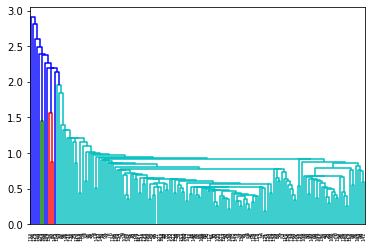

In [63]:
#Dendrograms using Single Linkage
df_hi=linkage(df2,method="single",metric="euclidean")
dendrogram(df_hi)
plt.show()

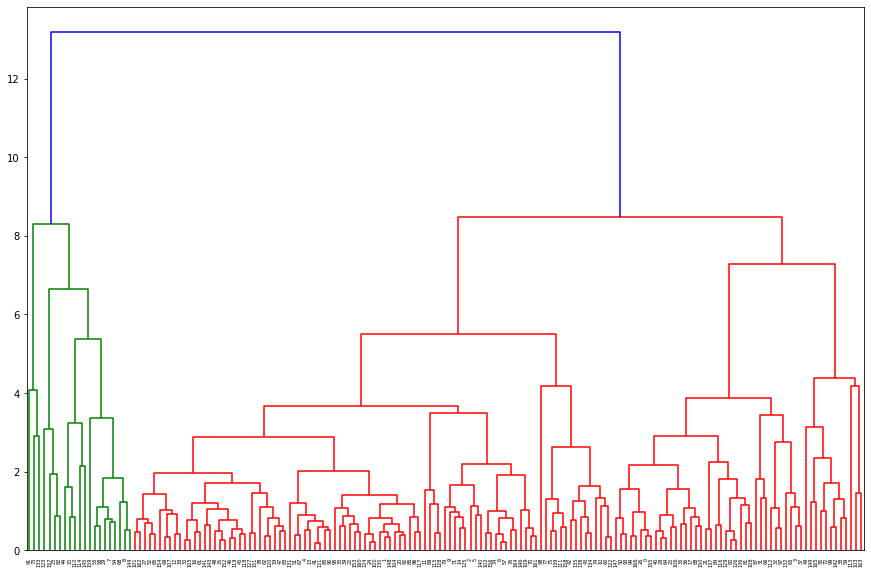

In [66]:
#Dendrograms using Complete Linkage
plt.figure(figsize=(15,10))
df_hi=linkage(df2,method="complete",metric="euclidean")
dendrogram(df_hi)
plt.show()

In [75]:
clustr_ids=cut_tree(df_hi,n_clusters=2)

In [76]:
clustr_ids=clustr_ids.reshape(-1,)
clustr_ids

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [77]:
df_km['cluster_id']=clustr_ids
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,100,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,101,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,102,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,103,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,104,0


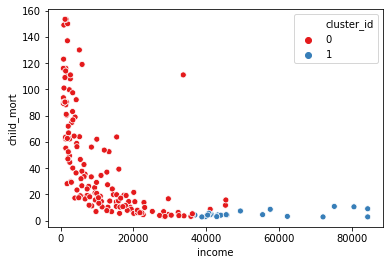

In [78]:
# Plot the Clusters for income vs child_mort
sns.scatterplot(x = 'income', y = 'child_mort', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

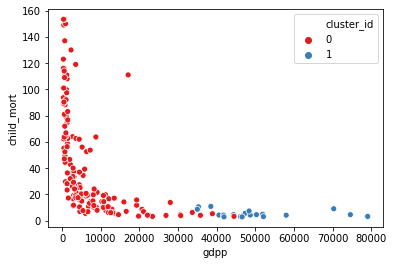

In [79]:
# Plot the Clusters for gdpp vs child_mort
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

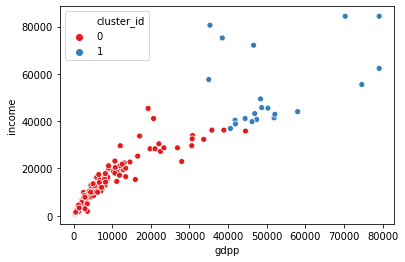

In [80]:
# Plot the Clusters for gdpp vs child_mort
sns.scatterplot(x = 'gdpp', y = 'income', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

### Cluster Profiling 

In [82]:
df_km.drop('ID', axis = 1).groupby('cluster_id')['child_mort','income','gdpp'].mean()

,child_mort,income,gdpp
cluster_id,,,
0,42.612329,11599.578630,7215.200274
1,5.176190,53421.333333,51289.333333


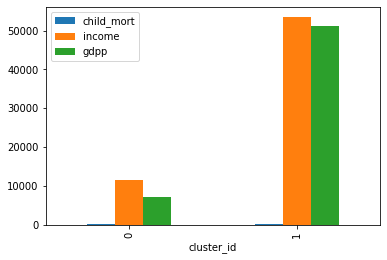

In [83]:
df_km.drop('ID', axis = 1).groupby('cluster_id')['child_mort','income','gdpp'].mean().plot(kind = 'bar')

In [84]:
#Cluster id 0 represents high child mortality , low gdpp and income

In [85]:
#Now lets find top five countries of cluster id 0 with high child mortality , low gdpp and income
df_km[df_km.cluster_id==0].sort_values(["child_mort", "gdpp","income"], ascending = (False,True, True)).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID,cluster_id
132,Sierra Leone,153.4,67.032,52.2690,137.655,1220.0,17.20,55.00,5.20,399.0,232,0
66,Haiti,153.4,101.286,45.7442,428.314,1500.0,5.45,47.16,3.33,662.0,166,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.39,56.50,6.59,897.0,132,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.01,47.50,5.21,446.0,131,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.37,59.50,6.55,708.0,197,0
